In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons

%load_ext autoreload
%autoreload 2


In [2]:
"""
# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    #Lorenz 96 model with constant forcing
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()
"""

'\n# These are our constants\nN = 5  # Number of variables\nF = 8  # Forcing\n\n\ndef L96(x, t):\n    #Lorenz 96 model with constant forcing\n    # Setting up vector\n    d = np.zeros(N)\n    # Loops over indices (with operations and Python underflow indexing handling edge cases)\n    for i in range(N):\n        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F\n    return d\n\n\nx0 = F * np.ones(N)  # Initial state (equilibrium)\nx0[0] += 0.01  # Add small perturbation to the first variable\nt = np.arange(0.0, 30.0, 0.01)\n\nx = odeint(L96, x0, t)\n\n# Plot the first three variables\nfig = plt.figure()\nax = fig.gca(projection="3d")\nax.plot(x[:, 0], x[:, 1], x[:, 2])\nax.set_xlabel("$x_1$")\nax.set_ylabel("$x_2$")\nax.set_zlabel("$x_3$")\nplt.show()\n'

In [3]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [4]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

In [5]:
begin = 0
end = 500
step = 1
tlen = int((end-begin)/step)
trainToTest = 0.8 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 2
t0 = np.ones(dim) * 0.0 # np.zeros(dim)
t0[0] += 0.1

In [6]:
# Discrete Time Systems
"""
# Munch Model, includes a time lag explicitly
trueLag = 4
initval = 2
r = 1.75 # vals used are 8, 3.5, 2.5, 1.75
states = np.zeros((tlen,1))
for i in range(tlen):
    if i <= trueLag:
        states[i] = initval
    else: 
        states[i] = r*states[i-1]*np.exp(-states[i-1-trueLag]+rand.normal(0,0.1,1))

"""

# Logistic Map
"""
r = lambda t : 0.25 * np.sin(t/30) + 3.75
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
""" 

# Density Dependent Maturation

states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

print(states[:25])


[[  5.         300.        ]
 [  2.27595966 316.55880898]
 [  1.86915429 233.64757706]
 [  2.9908468  177.85077892]
 [  4.00808094 189.60313338]
 [  3.90120479 230.11232016]
 [  3.24285089 243.41611906]
 [  2.99883906 232.58698947]
 [  3.17107982 215.51012678]
 [  3.48545051 216.10198948]
 [  3.51479138 223.09694159]
 [  3.41567712 230.96461181]
 [  3.29318439 232.42254397]
 [  3.27651583 225.73737665]
 [  3.40546992 224.93572743]
 [  3.44517119 223.69690099]
 [  3.48643502 228.04862929]
 [  3.43074836 230.82421168]
 [  3.39546295 237.29886875]
 [  3.2977384  232.71922636]
 [  3.38611723 228.28504234]
 [  3.48660773 228.93339902]
 [  3.49869053 236.23205137]
 [  3.38713667 240.53245857]
 [  3.3199941  233.18549845]]


In [7]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
"""
t0 = np.array([4,12,17])
states = odeint(Lorenz,t0,t)
# print(states)
# print(states)
# END STATIONARY SIMULATION
"""

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 28        # rho = 28.0
sigma = 10       # sigma = 10.0
beta = 8.0 / 3.0  # beta = 8.0 / 3.0

deltaP = 1
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP
"""
# END NON STATIONARY


'\nrho = 28        # rho = 28.0\nsigma = 10       # sigma = 10.0\nbeta = 8.0 / 3.0  # beta = 8.0 / 3.0\n\ndeltaP = 1\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]\n    sigma += deltaP\n'

In [8]:
# Normalize, split data
states = (states - states.mean(0) ) / states.std(0) # normalize
testTrainSplit = int(states.shape[0] * trainToTest)

X = states[:-1]
Y = states[1:,]
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
Xt = X[testTrainSplit:,]
Yt = Y[testTrainSplit:,]
X = X[:testTrainSplit,]
Y = Y[:testTrainSplit,]


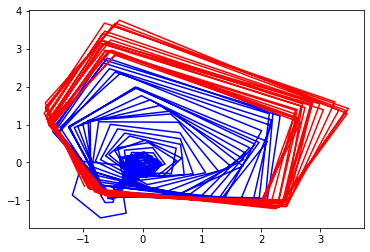

In [9]:
# Print Input
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(X,"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1],c="b")
    ax2.plot(Xt[:,0],Xt[:,1],c="r")
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
plt.savefig("result-train_data.png")

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

"""
fig, (lor0, lor1, lor2) = plt.subplots(nrows=1,ncols=3, figsize = (24,6))
lor0.plot(X[:,0],"b")
lor1.plot(X[:,1],"b")
lor2.plot(X[:,2],"b")
"""

plt.show()

# print(X.flatten())

In [10]:
# # # GP SETUP # # #

gp.setCovar("sqrexpf")
# gp.setPrior(1,"half-normal")
gp.setPrior(2,"half-normal")
gp.setPrior(3,"exponential")
gp.setData(X,Y)
gp.setTimeDelayInterval(1)

assignment = [1,1]
gp.setTimeDelayEmbedding(assignment)
Xt, Yt = delayEmbed(Xt,Yt,assignment,1)
# print(gp.X)
numparams = 4
for i in range(numparams,numparams+sum(assignment)):
    gp.setPrior(i,"ARD")
embDim = sum(assignment)


#print(type(X),type(Y),type(assignment))


Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential'}
Data input success
tmp  (400, 4)
r  [3.83299 4.21201]
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'none', 5: 'none'}
New X Dimensions  (398, 4)
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}


Hp:  [0, 0.15385, 0.18132, 0.00038, 0.01856, 0.01856]
Gradient:  [0.      0.15988 0.02135 0.9868  0.00434 0.01347]
Likelihood:  105.79255160420655
Hp:  [0.      0.27385 0.30132 0.12038 0.13856 0.13856]  #  1
Gradient:  [-0.      -0.41312 -0.04297 -0.90889 -0.02775 -0.0251 ]
Likelihood:  585.9135281774234
Hp:  [0.      0.21385 0.24132 0.06038 0.07856 0.07856]  #  2
Gradient:  [-0.      -0.25016 -0.02742 -0.96724 -0.02454 -0.02253]
Likelihood:  745.664912788415
Hp:  [0.      0.14185 0.16932 0.      0.00656 0.00656]  #  3
Gradient:  [0.      0.00003 0.00001 1.      0.00015 0.00041]
Likelihood:  -3660.058208904863
Hp:  [0.015   0.17785 0.20532 0.036   0.04256 0.04256]  #  4
Gradient:  [-0.13203 -0.1631  -0.0183  -0.97708 -0.0225  -0.02078]
Likelihood:  860.6429923292167
Hp:  [0.0075  0.15985 0.18732 0.018   0.02456 0.02456]  #  5
Gradient:  [-0.07525 -0.08839 -0.01052 -0.99278 -0.02055 -0.01925]
Likelihood:  1007.2303842421643
Hp:  [0.      0.13825 0.16572 0.      0.00296 0.00296]  #  6
Gr

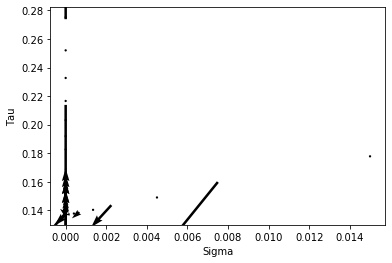

In [11]:
# 2.96355967e-05 3.10039090e+00 6.52724514e-03 9.60568331e-01
 #9.60568331e-01 9.60568331e-01
# optimize them parameters

# gp.setHP([0, 0.50058, 0.15199])
gp.setHP([0, 0.15385, 0.18132,0.00038,0.01856,0.01856])
gp.hyperParamOptimize(steps=40, yind=0) # <<<< THIS IS EXPENSIVE

In [12]:
print(gp.hp)

# One step predictions
diffTable = []
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    variances[i] = predTuple[1]
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    
    diff = la.norm(Yt[i] - predictions[i]) # norm error for 1 step
    diffTable.append(diff)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)

diffTable = np.array(diffTable)

[0.      0.2752  0.18721 0.00026 0.      0.     ]


In [13]:
# feed forward prediction
"""
n = 200 # num steps
feedForwardPrediction = np.zeros(((n,dim)))
feedForwardPrediction[0] = X[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]
"""

'\nn = 200 # num steps\nfeedForwardPrediction = np.zeros(((n,dim)))\nfeedForwardPrediction[0] = X[0]\nfor i in range(n-1):\n    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]\n'

Mean Squared Error:  1.0727624195722971


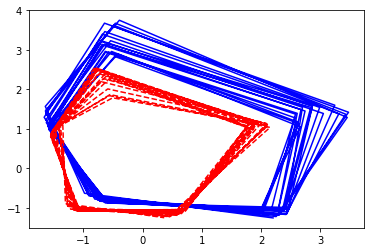

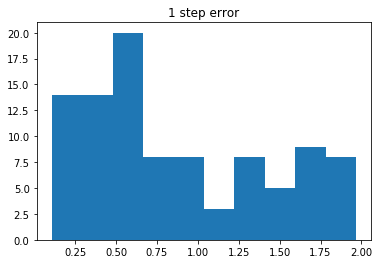

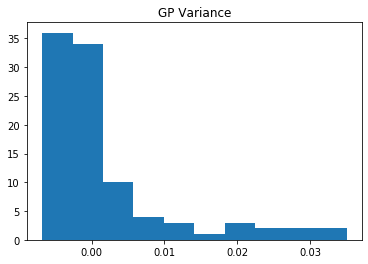

In [14]:
fig0 = plt.figure(0)
if dim == 1:
    ax0 = plt.subplot()
    ax0.plot(Yt[:75,0],"b") # states
    ax0.plot(predictions[:75,0],'--r')
elif dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

plt.savefig("result-error_vs_actual.png")
    
fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

mse = sum(diffTable ** 2) / len(diffTable)
print("Mean Squared Error: ",mse)

plt.savefig("result-error_histogram.png")

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

"""
fig, (lor0, lor1, lor2) = plt.subplots(nrows=1,ncols=3, figsize = (24,6))
lor0.plot(Yt[:,0],"b")
lor1.plot(Yt[:,1],"b")
lor2.plot(Yt[:,2],"b")
lor0.plot(predictions[:,0],"--r")
lor1.plot(predictions[:,1],"--r")
lor2.plot(predictions[:,2],"--r")
"""

plt.savefig("result-error_vs_actual_individual_dims.png")

plt.show()

[0.7666 0.8424]


IndexError: index 2 is out of bounds for axis 0 with size 2

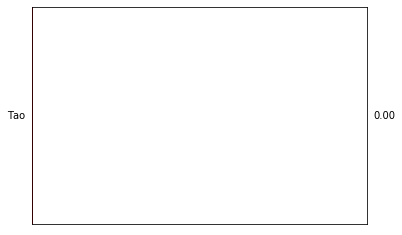

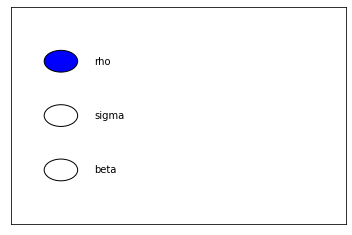

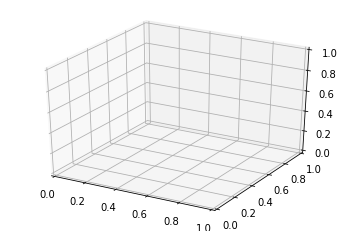

In [15]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()

In [16]:
print(gp.X)
np.savetxt("trainX.csv", gp.X, delimiter=",",fmt= '%.8f')
np.savetxt("trainY.csv", gp.Y, delimiter=",",fmt= '%.8f')
np.savetxt("testX.csv", Xt, delimiter=",",fmt= '%.8f')
np.savetxt("testY.csv", Yt, delimiter=",",fmt= '%.8f')


[[-1.18274 -0.86239 -1.01016 -0.14886]
 [-0.7069  -1.4624  -1.18274  0.0292 ]
 [-0.27537 -1.33602 -0.7069  -0.86239]
 ...
 [-1.50796  0.91267 -0.59429  1.22562]
 [-0.62551 -0.86037 -1.50796  2.74961]
 [ 2.0598  -1.06756 -0.62551  0.91267]]
